In [1]:
import multiprocessing as mp
import os
import nilearn.image
import numpy as np
from sklearn.decomposition import IncrementalPCA, PCA
from models.dataloaders import *
import pandas as pd
import torch
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from sklearn import manifold
from collections import Counter


In [2]:

def print_mem_of_array(x):
    bytes = x.size * x.itemsize
    print(f"{np.round(bytes/1e+9,2)} Gb")


def plot_tsne(x,label,perplexity,mapping):


    plt.figure(figsize=(8, 8))
    cat_as_int = mapping.values()
    cat_as_str = mapping.keys()
    N = len(cat_as_str)

    cmap = plt.cm.get_cmap("hsv", N+1)
    cmap_list = [cmap(i) for i in range(N)]
    for color, i, target_name in zip(cmap_list, cat_as_int, cat_as_str):
        print(f"Number of examples for group {target_name}= {len(x[label==i])}")
        plt.scatter(x[label == i, 0], x[label == i, 1],
                    color=color, lw=2, label=target_name)

    plt.title(f"N={len(label)}; Perplexity={perplexity}")
    plt.legend(loc="upper right")
    plt.savefig(f"tsne_mri_p{perplexity}.png")
    #ax.axis('tight')
    plt.show()

    
def find_drug_of_abuse(x):
    if len(x) > 3:
        return x[:3]
    return x


def find_balanced_subsets(N,path,label):

    df = pd.read_csv(path)
    
    #if label == "drug":
    #df["drug"] = df["study"].apply(lambda x: find_drug_of_abuse(x))
    
    # filter only addicts
    #df = df[df["dependent"]==1]
    #filter out cann and ats
    #df = df[(df["drug"]!="CANN") | (df["drug"]!="ATS")]
    
    labels = df[label].unique()
    mapping={}
    for i,lab in enumerate(labels):
#         if "CANN" in lab or "ATS" in lab:
#             mapping[lab] = -1
        mapping[lab] = i
        print(f"Mapping: {lab} to {mapping[lab]}")

    df = df.replace({label: mapping})
    labels = []
    dfg = df.groupby(label)
    data = []
    for name, subdata in dfg:
#         if name < 0:
#             continue
        l = len(subdata[label])
        N = l if l < N else N 
        print(f"Group: {name}, N= {N}")
        data.extend(subdata["filename"][:N].values)
        labels.extend(subdata[label][:N].values)

    # shuffle
    data = np.array(data).reshape(-1)
    labels=np.array(labels).reshape(-1)
    ind = np.random.choice(len(labels),len(labels),replace=False)

    labels = labels[ind]
    data= data[ind]

    assert data.shape[0] == labels.shape[0]

    return data, labels, mapping



def ipca_transform(ipca,batch):
    #x, label = batch
    x = batch['image'][tio.DATA]
    label = batch['label']
    batch_size = x.shape[0]
    partial_x = x.squeeze().reshape(batch_size, -1)
    #label.append(label.numpy())
    partial_x_transform = ipca.transform(partial_x)
    #x_transform.append(partial_x_transform)
    # x_transform = np.vstack((x_transform, partial_x_transform))
    return (partial_x_transform, label)


def multiprocess_transform(ipca, dataloader, batch_size, ncpus=None):


    if ncpus is None:
        ncpus = int(os.environ.get('SLURM_CPUS_PER_TASK', default=1))

    x_transform = []
    label = []

    pool = mp.Pool(processes=ncpus)

    print(f"Multiprocessing using {ncpus} cpus")
    results = [pool.apply_async(ipca_transform, args=(ipca,batch,)) for batch in dataloader]
    #x_transform = [p.get() for p in results]

    for p in results:
        res = p.get()
        x_transform.append(res[0])
        label.append(res[1])

    x_transform = np.concatenate(x_transform)
    label = np.concatenate(label)

    return x_transform, label


def sequential_transform(ipca, dataloader, batch_size, ncpus=None):


    x_transform = []
    label = []

    for i,batch in enumerate(dataloader):
        print(f"Transforming batch {i}")
        result = ipca_transform(ipca,batch)
        x_transform.append(result[0])
        label.append(result[1])


    x_transform = np.concatenate(x_transform)
    label = np.concatenate(label)

    return x_transform, label


def iterative_pca(batch_size,dataloader,n_components,out_name,multiprocessing=False):

    if n_components > batch_size:
        print(f"n_components can't be smaller than batch_size, resizing to n_components = batch_size.")
        n_components = batch_size

    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

    # compute necessary paramters iteratively
    print("Fitting IPCA...")
    for i, batch in enumerate(dataloader):
        x = batch['image'][tio.DATA]
        y = batch['label']
        data = x.squeeze().reshape(x.shape[0], -1)
        print(f"iter: {i}, data shape: {data.shape}")
        ipca.partial_fit(data)

    print("Transforming input using estimates from fit...")
    if multiprocessing:
        x_transform, label = multiprocess_transform(ipca, dataloader, batch_size, ncpus=None)
    else:
        x_transform, label = sequential_transform(ipca, dataloader, batch_size, ncpus=None)

    print("Saving result under data directory.")
    np.save(f'/scratch/spinney/enigma_drug/data/x_{out_name}.npy', x_transform, allow_pickle=True)
    np.save(f'/scratch/spinney/enigma_drug/data/label_{out_name}.npy', label, allow_pickle=True)

    return x_transform, label

In [3]:
def tsne(path,label_name,N,batch_size,num_workers,out_name,perplexities, pca_dim_reduction,clobber=True):

    if not os.path.exists(f"/scratch/spinney/enigma_drug/data/x_{out_name}.npy") or clobber:

        image_paths, labels, mapping = find_balanced_subsets(N, path,label_name)

        indices = np.arange(len(labels))
        print(Counter(labels))
        print(f"Number of unique classes: {len(Counter(labels))}")
        dm = MRIDataModuleIO(path, labels, 'nifti', batch_size, None, '', image_paths, num_workers, True)
        
        dm.prepare_data()
        dm.setup(stage='fit')
        
        out_name = f"{out_name}_{label_name}"
        x_transform, label = iterative_pca(batch_size, dm.train_dataloader(), pca_dim_reduction, out_name)
        np.save(f'/scratch/spinney/enigma_drug/data/mapping_{label_name}.npy', mapping, allow_pickle=True)

    else:
        print("Files located, loading in progres...")
        x_transform = np.load(f'/scratch/spinney/enigma_drug/data/x_{out_name}.npy', allow_pickle=True)
        label =  np.load(f'/scratch/spinney/enigma_drug/data/label_{out_name}.npy', allow_pickle=True)
        mapping = np.load(f'/scratch/spinney/enigma_drug/data/mapping_{label_name}.npy', allow_pickle=True)
        print("MAPPING")
        mapping=mapping.item()
        print(mapping)


    print(f"Shape of input: {x_transform.shape}")
    print(f"Shape of labels: {label.shape}")

    print(f"Size of input data on disk")
    print_mem_of_array(x_transform)

    #  tsne

    for i, perplexity in enumerate(perplexities):
        #ax = subplots[0][i + 1]

        #t0 = time()
        tsne = manifold.TSNE(n_components=2, init='random',
                             random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(x_transform)
        #t1 = time()

        print("Completed and plotting results...")
        plt.clf()
        plot_tsne(Y, label, perplexity,mapping)



Mapping: 1 to 0
Mapping: 3 to 1
Mapping: 4 to 2
Mapping: 2 to 3
Mapping: 0 to 4
Group: 0, N= 200
Group: 1, N= 134
Group: 2, N= 134
Group: 3, N= 134
Group: 4, N= 134
Counter({0: 200, 2: 134, 3: 134, 1: 134, 4: 134})
Number of unique classes: 5
Class_count: tensor([141,  96,  92, 104,  97])


/project/6003972/spinney/mri_classification/models/dataloaders.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(class_sample_count[1] / (class_sample_count[0] + 1e-5), dtype=torch.float)


Fitting IPCA...
iter: 0, data shape: torch.Size([100, 6299328])
iter: 1, data shape: torch.Size([100, 6299328])
iter: 2, data shape: torch.Size([100, 6299328])
iter: 3, data shape: torch.Size([100, 6299328])
iter: 4, data shape: torch.Size([100, 6299328])
Transforming input using estimates from fit...
Transforming batch 0
Transforming batch 1
Transforming batch 2
Transforming batch 3
Transforming batch 4
Saving result under data directory.
Shape of input: (500, 50)
Shape of labels: (500,)
Size of input data on disk
0.0 Gb
Completed and plotting results...
Number of examples for group 1= 107
Number of examples for group 3= 104
Number of examples for group 4= 96
Number of examples for group 2= 97
Number of examples for group 0= 96


<Figure size 432x288 with 0 Axes>

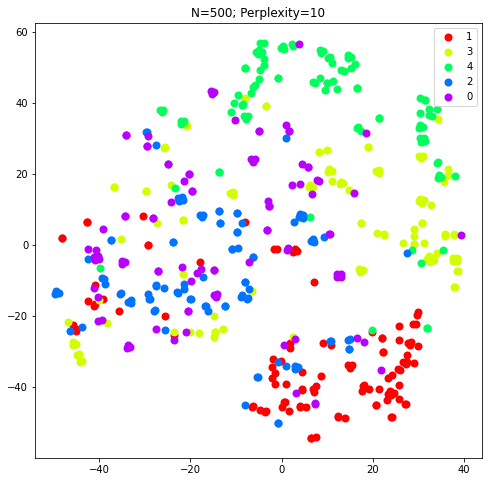

Completed and plotting results...
Number of examples for group 1= 107
Number of examples for group 3= 104
Number of examples for group 4= 96
Number of examples for group 2= 97
Number of examples for group 0= 96


<Figure size 432x288 with 0 Axes>

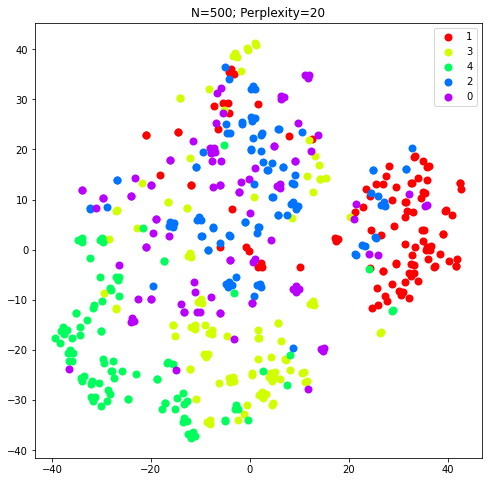

Completed and plotting results...
Number of examples for group 1= 107
Number of examples for group 3= 104
Number of examples for group 4= 96
Number of examples for group 2= 97
Number of examples for group 0= 96


<Figure size 432x288 with 0 Axes>

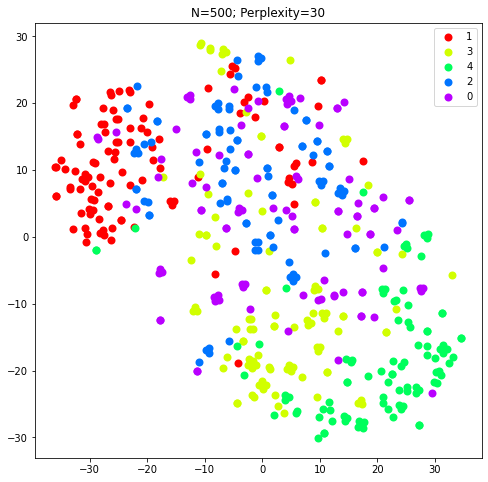

Completed and plotting results...
Number of examples for group 1= 107
Number of examples for group 3= 104
Number of examples for group 4= 96
Number of examples for group 2= 97
Number of examples for group 0= 96


<Figure size 432x288 with 0 Axes>

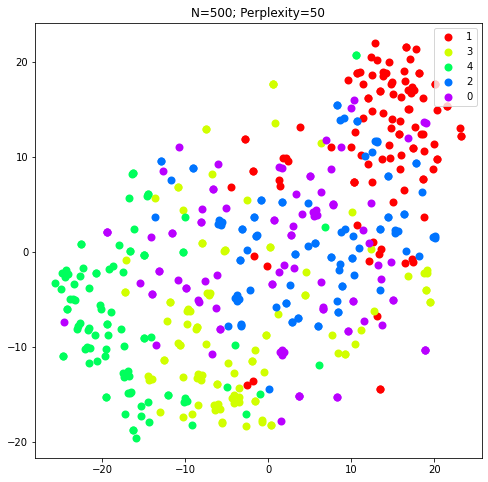

Completed and plotting results...
Number of examples for group 1= 107
Number of examples for group 3= 104
Number of examples for group 4= 96
Number of examples for group 2= 97
Number of examples for group 0= 96


<Figure size 432x288 with 0 Axes>

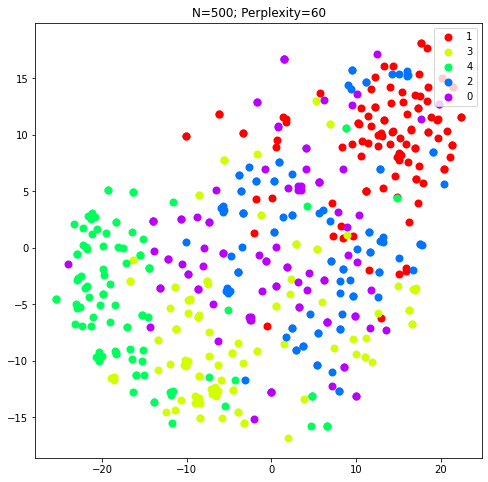

In [5]:

data_dir = "/scratch/spinney/enigma_drug/data/data_split_c.csv"
batch_size=100
num_workers=3
max_samples=200 #per group
out_name="tsne_mri"

perplexities = [10,20,30,50,60]
pca_dim_reduction = 50
#label= "dependent"
label= "class"

tsne(data_dir,label,max_samples, batch_size, num_workers, out_name,perplexities,pca_dim_reduction,clobber=True)